# Preprocessor
   1. Convert TIFF video to individual TIFF images
        > Clearing the folder and index+1 to have the range 1-300 added
   2. Implement OpenCV for circle detection 
   3. Identify the Largest circle detected
   4. Establish a bounding rectangular area around the circle
   5. Perform cropping based on the bounding rectangular
   6. Save processed data

#### 1. Converting TIFF

In [1]:
import os
import numpy as np
import tifffile
from PIL import Image

# Read the image
imageAll = tifffile.imread('CaSki17.tif')
lengthOfStack = imageAll.shape[0]  # Get the length of the stack
dirToStore = "C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/"

for file in os.listdir(dirToStore):
    os.remove(os.path.join(dirToStore, file))

for index in range(lengthOfStack):  # Loop through each frame
    image = np.array(imageAll[index, :, :], dtype=np.uint16)
    image = Image.fromarray(image) # Convert to PIL Image
    image.save(f"{dirToStore}{index+1}.tif")

<tifffile.TiffTag 5033 @530880> coercing invalid ASCII to bytes


#### 2. Implementing OpenCV 

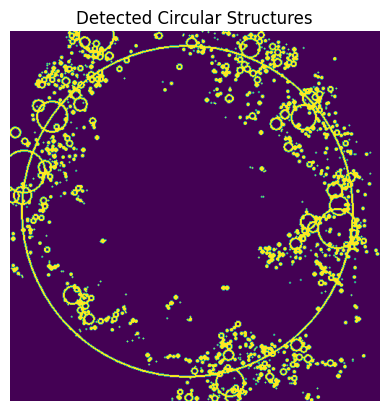

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, color, filters, measure

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'

try:
    image = io.imread(image_path)
except FileNotFoundError:
    print("Error: Unable to load the image.")
    exit()

# Convert image to grayscale
if image.ndim > 2:
    image_gray = color.rgb2gray(image)
else:
    image_gray = image

# Apply median blur for noise reduction (can be also Gaussian blur)
blurred = filters.median(image_gray)


thresholded = blurred > filters.threshold_otsu(blurred)


label_image = measure.label(thresholded)


contour_image = np.zeros_like(image, dtype=np.uint8)


for region in measure.regionprops(label_image):
    min_row, min_col, max_row, max_col = region.bbox
    centroid_row, centroid_col = region.centroid
    radius = int(max((max_row - min_row), (max_col - min_col)) / 2)

    # Draw the circle on the contour image
    cv2.circle(contour_image, (int(centroid_col), int(centroid_row)), radius, (255, 255, 255), 2)


contour_image_path = os.path.splitext(image_path)[0] + '_contour.tif'
io.imsave(contour_image_path, contour_image)


plt.imshow(contour_image)
plt.title('Detected Circular Structures')
plt.axis('off')
plt.show()


#### OpenCV and Scikit-Image approach

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, color, filters, morphology
import cv2

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'

try:
    image = io.imread(image_path)
except FileNotFoundError:
    print("Error: Unable to load the image.")
    exit()

# Convert image to grayscale
if image.ndim > 2:
    image_gray = color.rgb2gray(image)
else:
    image_gray = image

# Apply median blur for noise reduction (can be also Gaussian blur)
blurred = filters.median(image_gray)

# Threshold the image to obtain binary image
thresholded = blurred > filters.threshold_otsu(blurred)

# Remove small objects and fill holes
cleaned = morphology.remove_small_objects(thresholded, min_size=100)
cleaned = morphology.remove_small_holes(cleaned)

# Hough circle detection
circles = cv2.HoughCircles(cleaned.astype(np.uint8), cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=5, maxRadius=100)

if circles is not None:
    circles = np.uint16(np.around(circles))
    
    # Create a black image for drawing circles
    circle_image = np.zeros_like(image, dtype=np.uint8)
    
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        
        # Draw the circle on the circle image
        cv2.circle(circle_image, center, radius, (255, 255, 255), 2)

    # Save the circle image
    circle_image_path = os.path.splitext(image_path)[0] + '_circle.tif'
    io.imsave(circle_image_path, circle_image)

    # Display the circle image
    plt.imshow(circle_image)
    plt.title('Detected Circular Structures')
    plt.axis('off')
    plt.show()
else:
    print("No circles detected.")

No circles detected.


#### CellPose

100%|██████████| 25.3M/25.3M [00:16<00:00, 1.61MB/s]
100%|██████████| 5.23k/5.23k [00:00<?, ?B/s]


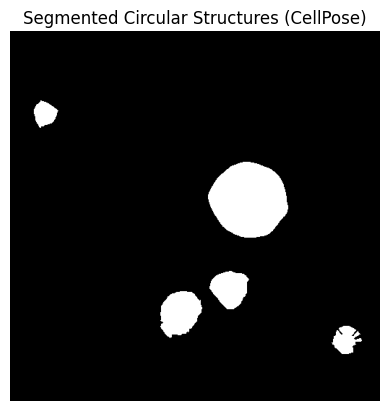

In [37]:
import cv2
from cellpose import models, utils

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

# Save the segmented circular structures
segmented_image_path = 'segmented_circular_structures.tif'
cv2.imwrite(segmented_image_path, masks_uint16)

# Display the segmented circular structures
plt.imshow(masks_uint16, cmap='gray')
plt.title('Segmented Circular Structures (CellPose)')
plt.axis('off')
plt.show()


Radius of the biggest detected membrane: 54.000099182128906


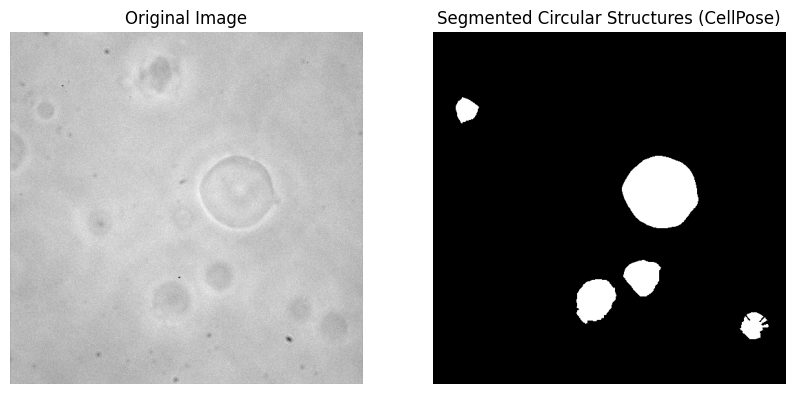

In [68]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Contrast stretching
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535


max_radius = 0
for mask in masks:
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        max_radius = max(max_radius, radius)

print("Radius of the biggest detected membrane:", max_radius)

# Display the segmented membranes
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('Segmented Circular Structures (CellPose)')
plt.axis('off')
plt.show()


Radius of the biggest detected membrane: 55.901798248291016


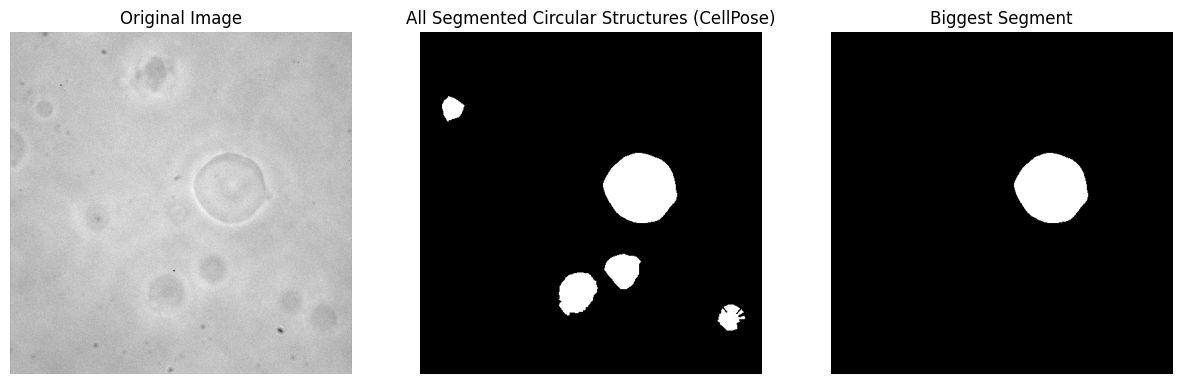

In [82]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Contrast stretching
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

max_radius = 0
max_contour = None

contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    if radius > max_radius:
        max_radius = radius
        max_contour = contour

print("Radius of the biggest detected membrane:", max_radius)

# Extract the segmented area of the biggest contour
biggest_segment_mask = np.zeros_like(image)
cv2.drawContours(biggest_segment_mask, [max_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Display the segmented membranes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('All Segmented Circular Structures (CellPose)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(biggest_segment_mask, cmap='gray')
plt.title('Biggest Segment')
plt.axis('off')

plt.show()
